# 2. 离散贝叶斯

In [2]:
%matplotlib inline

In [3]:
#format the book
import book_format
book_format.set_style()

卡尔曼滤波器属于一类称为*贝叶斯滤波器*的滤波器。大多数关于卡尔曼滤波器的教材会介绍贝叶斯公式，可能会展示它如何融入卡尔曼滤波器方程，但大多数内容都停留在非常抽象的层面上。

这种方法需要读者对多个数学领域有相当深入的理解，同时仍然需要读者努力理解和形成直观把握问题的工作。

我将采用一种不同的方式来发展这个主题，这得益于Dieter Fox和Sebastian Thrun的工作。它依赖于通过跟踪一个对象穿过走廊来建立对贝叶斯统计工作原理的直观理解-他们使用的是机器人，而我使用的是一只狗。我喜欢狗，它们比机器人更难以预测，这给滤波带来了有趣的难题。我能找到的第一个发表的例子似乎是Fox在1999年的文章[1]，而在他在2003年的更详尽的例子[2]中也提到了。Sebastian Thrun在他出色的Udacity课程《人工智能与机器人技术》[3]中也使用了这种表述。实际上，如果你喜欢看视频，我强烈推荐你暂停阅读本书，先观看该课程的前几课，然后再回到这本书深入探讨这个主题。

现在让我们像我们对待g-h滤波器那样，使用一个简单的思维实验，来看看我们如何用概率来思考滤波和跟踪的应用。

# 追踪一只狗

让我们从一个简单的问题开始。我们的工作空间允许员工携带他们的狗来上班。有时这些狗会走出办公室，在走廊上漫游。我们想要追踪它们的位置。所以在一次黑客马拉松中，有人发明了一种可以附在狗项圈上的声纳传感器。它发出信号，接收回声，并根据回声的返程时间判断狗是否在开着的门前。它还能感知狗的行走，并报告狗移动的方向。它通过WiFi连接到网络，每秒发送一次更新。

我想追踪我的狗西蒙，所以我把这个设备安装在了它的项圈上，然后启动Python准备编写代码来追踪它穿过建筑物。乍一看，这似乎是不可能的。如果我开始监听西蒙项圈的传感器，我可能会读到**门**，**走廊**，**走廊**，等等。我怎么能利用这些信息确定西蒙在哪里呢？

为了让问题简单到容易绘制，我们假设走廊上只有10个位置，我们将它们编号为0到9，其中1位于0的右侧。出于稍后将会清楚的原因，我们还假设走廊是环形或矩形的。如果你从位置9向右移动，你将回到位置0。

当我开始监听传感器时，我没有理由相信西蒙在走廊的任何特定位置。在我的观察中，它在任何给定位置的可能性都是相等的。总共有10个位置，因此它在任何给定位置的概率是1/10。

让我们用一个NumPy数组来表示我们对它位置的信念。我可以使用Python列表，但是NumPy数组提供了我们很快就要使用的功能。

In [4]:
import numpy as np
belief = np.array([1/10]*10)
print(belief)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


贝叶斯统计是一种处理概率的方法，但与我们通常所说的概率有些不同。传统的概率常常描述事件发生的频率，比如抛硬币出现正反面的概率各为50%。但是，当我们面对一个具体事件时，比如我刚刚抛的这个硬币会是正面朝上的概率是多少？这时，贝叶斯统计给出的是我对这个事件的信心程度，我相信它是正面的可能性有多大。这个信心程度取决于我之前所知道的信息，比如硬币的权重或者我对这个硬币的了解。

这种贝叶斯方法，其实就是将过去的知识（先验）考虑在内。比如，如果我知道每100天下雨4次，那么对于明天下雨的预测，贝叶斯方法会考虑今天是否在下雨、天气情况等先前的信息，来估计明天下雨的概率。实际应用中，统计学家常常会综合运用贝叶斯和传统频率方法。这里我们可以先设定一个先验，也就是基于过去的信息对事件发生的概率的初始估计。

现在，我们要在走廊中追踪一只狗的位置。假设我们的走廊有10个位置，分别编号为0到9，1紧挨着0。我们把1作为门，0作为墙壁。我们使用Python来表示这个走廊地图：

In [5]:
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

我开始收集Simon在网络上发送的数据，第一个传感器传回的数据是**door**。暂且假设传感器总是返回正确的答案。根据这个数据，我可以推断Simon在门前，但是哪扇门呢？我没有理由相信他是在第一扇门前、第二扇门前还是第三扇门前。我可以给每扇门分配一个概率。所有的门都是同等可能的，而且有三扇门，所以我为每扇门分配了1/3的概率。

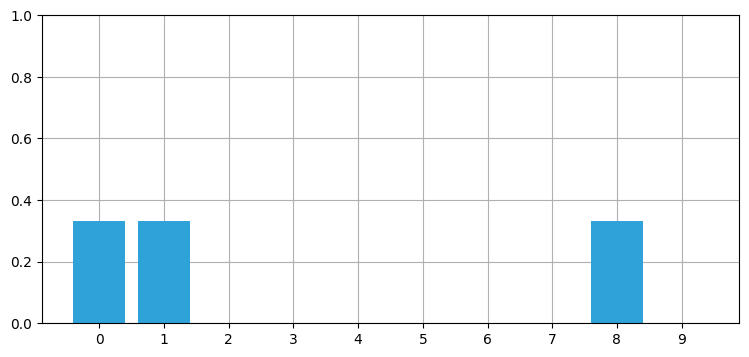

In [6]:
import kf_book.book_plots as book_plots
from kf_book.book_plots import figsize, set_figsize
import matplotlib.pyplot as plt

belief = np.array([1/3, 1/3, 0, 0, 0, 0, 0, 0, 1/3, 0])
book_plots.bar_plot(belief)

这个分布被称为分类分布，它是描述观察 𝑛 次结果的离散分布。这是一个多峰分布，因为我们对狗的位置有多种信念。当然，我们并不是在说我们认为它同时在三个不同的地方，而是我们已经将我们的知识缩小到了这三个地点之一。我的（贝叶斯）信念是门0有33.3%的概率，门1有33.3%的概率，门8有33.3%的概率。

这样改进了两个方面。首先，我拒绝了一些不可能的走廊位置，并且我对剩下的位置的信念强度从10%提高到了33%。这种情况总是会发生的。随着我们的知识改善，概率将接近100%。

关于分布的模态（mode）有几句话。给定一组数字，比如{1, 2, 2, 2, 3, 3, 4}，模态是出现最频繁的数字。对于这个集合，模态是2。一个分布可以包含多个模态。列表{1, 2, 2, 2, 3, 3, 4, 4, 4}包含模态2和4，因为它们都出现了三次。我们说前一个列表是单峰的，后一个列表是多峰的。

这种分布的另一个称呼是直方图。直方图以图形方式描述一组数字的分布。上面的条形图就是一个直方图。

我在上面的代码中手动编写了信念数组。我们如何在代码中实现这一点呢？我们用1表示门，用0表示墙，所以我们将走廊变量乘以百分比，如下所示：

In [7]:
belief = hallway * (1/3)
print(belief)

[0.333 0.333 0.    0.    0.    0.    0.    0.    0.333 0.   ]


# 从传感器读数中提取信息

让我们暂时不考虑Python，思考一下这个问题。假设我们从Simon的传感器读取到以下数据：
  * door
  * move right
  * door

我们能推断出Simon的位置吗？当然可以！考虑到走廊的布局，只有一个地方可以得到这个序列，那就是在最左边。因此，我们可以确信Simon现在在第二扇门前。如果这不够清楚，假设Simon最开始在第二或第三扇门前。向右移动后，他的传感器会返回'wall'。这与传感器的读数不符，因此我们知道他没有从那里开始。我们可以继续对所有剩余的起始位置使用这个逻辑。唯一的可能性就是他现在在第二扇门前。我们的信念是：

In [8]:
belief = np.array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

我设计了走廊的布局和传感器读数，以便快速得出确切答案。然而，现实中的问题并非如此明确。但这应该启发你的直觉——第一次传感器读数仅令我们对Simon的位置有了较低的概率（0.333）认知，但在进行位置更新和另一次传感器读数后，我们对他的位置有了更多了解。或许你会猜测，如果走廊非常长，有很多门，在经过多次传感器读数和位置更新后，我们要么能够确定Simon在哪里，要么将可能性缩小到很少的几个位置。当一组传感器读数仅匹配一个或少数起始位置时，这是可能的。

我们可以立即实施这个解决方案，但我们先来考虑一下问题中的真实世界复杂性。

# 传感器噪音

没有完美的传感器。也许传感器在西蒙（Simon）坐在门口挠痒时无法探测到门，或者如果他没有面向走廊，可能会出现读数错误。因此，当我得到“door”这样的读数时，不能简单地将概率分配为1/3。我需要为每扇门分配小于1/3的概率，并给每个空白墙面位置分配一个较小的概率。可能会像这样：

```Python
[.31, .31, .01, .01, .01, .01, .01, .01, .31, .01]
```

这个问题乍看之下可能有些难以解决。如果传感器存在噪声，就会对每个数据产生怀疑。如果我们一直不确定，那么怎么能得出结论呢？

答案就在于概率，就像上面的问题一样。我们已经习惯为狗的位置分配概率信念；现在我们必须考虑传感器噪声带来的额外不确定性。

假设我们得到一个“door”的读数，并且测试显示传感器正确的可能性是错误的三倍。在门口，我们应该将概率分布缩放三倍。如果我们这样做，结果将不再是一个概率分布，但我们将学会如何解决这个问题。

让我们用 Python 代码来看看这个过程。这里我使用变量 `z` 表示测量值。在文献中，`z` 或 `y` 是测量的习惯选择。作为程序员，我更喜欢有意义的变量名，但我希望你能够阅读文献或其他滤波代码，所以我现在开始引入这些缩写名字。

belief: [0.3 0.3 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.1]
sum = 1.6000000000000003


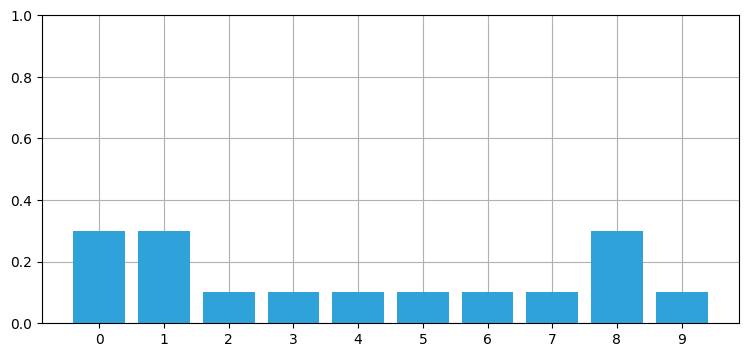

In [9]:
def update_belief(hall, belief, z, correct_scale):
    for i, val in enumerate(hall):
        if val == z:
            belief[i] *= correct_scale

belief = np.array([0.1] * 10)
reading = 1 # 1 is 'door'
update_belief(hallway, belief, z=reading, correct_scale=3.)
print('belief:', belief)
print('sum =', sum(belief))
plt.figure()
book_plots.bar_plot(belief)

这不是一个概率分布，因为它的总和不是1.0。但这段代码基本做对了——门被赋予了一个数值（0.3），是墙（0.1）的3倍。我们只需要对结果进行归一化，使概率正确地总和为1.0。归一化是通过将列表中的每个元素除以所有元素的总和来完成的。用 NumPy 很容易实现：

In [10]:
belief / sum(belief)

array([0.188, 0.188, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.188,
       0.062])

FilterPy 使用 `normalize` 函数来实现这个操作：

```Python
from filterpy.discrete_bayes import normalize
normalize(belief)
```

在这里说“正确的概率是错误的3倍”有些奇怪。我们正在处理概率，所以让我们指定传感器正确的概率，并从中计算比例因子。其方程为：

$$scale =  \frac{prob_{correct}}{prob_{incorrect}} = \frac{prob_{correct}} {1-prob_{correct}}$$

另外，使用 `for` 循环有些麻烦。通常情况下，你会希望在 NumPy 代码中避免使用 `for` 循环。NumPy 是用 C 和 Fortran 实现的，因此如果避免使用循环，结果通常会比相应的循环快100倍。

我们如何摆脱这个 `for` 循环？NumPy 允许您使用布尔数组对数组进行索引。您可以使用逻辑运算符创建布尔数组。我们可以通过以下方式找到走廊中的所有门：

In [11]:
hallway == 1

array([ True,  True, False, False, False, False, False, False,  True,
       False])

当您将布尔数组用作另一个数组的索引时，它将仅返回索引为 `True` 的元素。因此，我们可以用以下方式替换 `for` 循环：

```python
belief[hall==z] *= scale
```
只有与 `z` 相等的元素会乘以 `scale`。

教授您 NumPy 超出了本书的范围。我会使用惯用的 NumPy 结构，并在首次引入时对其进行解释。如果您对 NumPy 不熟悉，有很多博客文章和视频介绍如何高效和习惯地使用 NumPy。

以下是改进后的版本：

sum = 1.0
probability of door = 0.1875
probability of wall = 0.06249999999999999


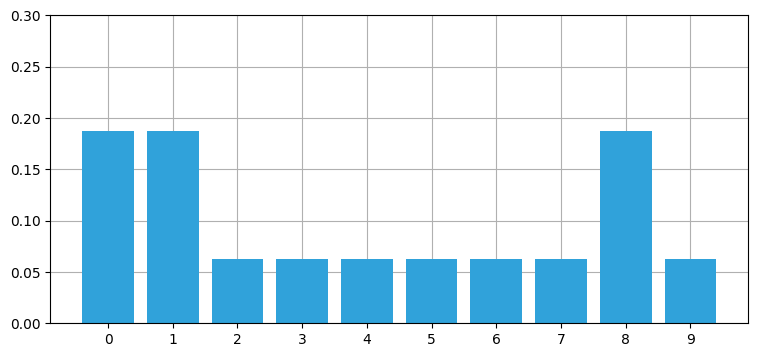

In [13]:
from filterpy.discrete_bayes import normalize

def scaled_update(hall, belief, z, z_prob): 
    scale = z_prob / (1. - z_prob)
    belief[hall==z] *= scale
    normalize(belief)

belief = np.array([0.1] * 10)
scaled_update(hallway, belief, z=1, z_prob=.75)

print('sum =', sum(belief))
print('probability of door =', belief[0])
print('probability of wall =', belief[2])
book_plots.bar_plot(belief, ylim=(0, .3))

这个结果称为[*后验概率*](https://en.wikipedia.org/wiki/Posterior_probability)，即在整合测量信息（后验意味着在这种情况下是“之后”）后的概率分布。回顾一下，*先验*是在包括测量信息之前的概率分布。

另一个术语是[*似然函数*](https://en.wikipedia.org/wiki/Likelihood_function)。当我们计算 `belief[hall==z] *= scale` 时，我们在计算每个位置在给定测量情况下的*可能性*。似然性不是一个概率分布，因为它的总和不为1。

这两者的结合给出了下面的方程：

$$\mathtt{posterior} = \frac{\mathtt{likelihood} \times \mathtt{prior}}{\mathtt{normalization}}$$

当我们谈论滤波器的输出时，通常将执行预测后的状态称为*先验*或*预测*，将更新后的状态称为*后验*或*估计状态*。

学习并内化这些术语非常重要，因为大多数文献广泛使用这些术语。

`scaled_update()` 执行这个计算吗？是的。让我将其转换成这种形式：

In [18]:
def scaled_update(hall, belief, z, z_prob): 
    scale = z_prob / (1. - z_prob)
    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    return normalize(likelihood * belief)

这个函数并不完全通用。它包含了对走廊以及如何匹配测量值的知识。我们总是希望编写通用函数。在这里，我们将移除函数中的似然值计算部分，并要求调用者自行计算似然值。

下面是算法的一个完整实现：

```python
def update(likelihood, prior):
    return normalize(likelihood * prior)
```

传感器测量的方式因问题而异。举例来说，传感器可能不只返回1或0，还可能返回0到1之间的小数，表示在门前的概率大小。或者它可能使用计算机视觉来报告一种斑点形状，然后通过概率匹配来判断是否是门。又或者它可能使用声纳返回距离读数。每种情况下，计算似然值的方法都有所不同。在这本书中，我们会看到很多这样的例子，并学习如何进行这些计算。

FilterPy 实现了`update`。下面是之前示例的一个完全通用的形式：

In [19]:
from filterpy.discrete_bayes import update

def lh_hallway(hall, z, z_prob):
    """ compute likelihood that a measurement matches
    positions in the hallway."""
    
    try:
        scale = z_prob / (1. - z_prob)
    except ZeroDivisionError:
        scale = 1e8

    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    return likelihood

belief = np.array([0.1] * 10)
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
update(likelihood, belief) 

array([0.188, 0.188, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.188,
       0.062])

# 融入运动

我们记得在融入一系列的测量和移动更新后，我们能够快速找到一个确切的解决方案。然而，那是在一个理想传感器的虚拟世界中发生的。使用嘈杂的传感器，我们能找到确切的解决方案吗？

不幸的是，答案是否定的。即使传感器读数与一个非常复杂的走廊地图完全匹配，我们也不能百分之百确定狗狗在特定位置——毕竟，每个传感器读数都有极小的可能是错误的！当然，在更典型的情况下，大多数传感器读数都是正确的，我们可能非常接近100%确信我们的答案，但永远也不会是100%确定。这可能听起来有些复杂，但我们继续来编写数学代码。

首先，让我们处理简单的情况——假设移动传感器是完美的，并报告狗狗向右移动了一个位置。我们应该如何更改我们的`belief`数组呢？

我希望稍作思考后就能明确，我们应该将所有的值都向右移动一个位置。如果我们之前认为Simon在位置3的概率是50%，那么在他向右移动一个位置后，我们应该相信他在位置4的概率也是50%。走廊是循环的，因此我们将使用模运算来进行移位。

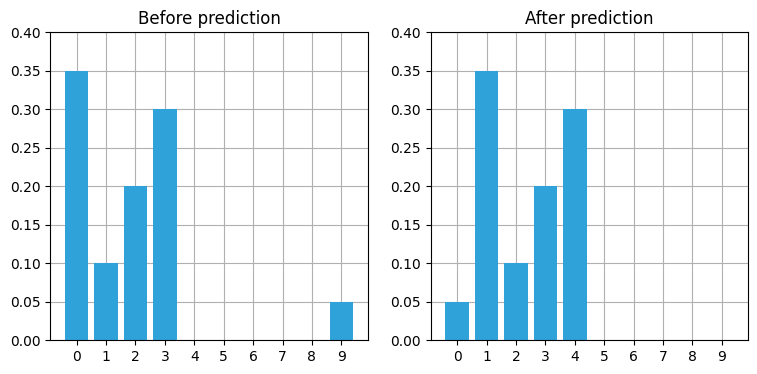

In [20]:
def perfect_predict(belief, move):
    """ move the position by `move` spaces, where positive is 
    to the right, and negative is to the left
    """
    n = len(belief)
    result = np.zeros(n)
    for i in range(n):
        result[i] = belief[(i-move) % n]
    return result
        
belief = np.array([.35, .1, .2, .3, 0, 0, 0, 0, 0, .05])
plt.subplot(121)
book_plots.bar_plot(belief, title='Before prediction', ylim=(0, .4))

belief = perfect_predict(belief, 1)
plt.subplot(122)
book_plots.bar_plot(belief, title='After prediction', ylim=(0, .4))

我们可以看到，我们将所有值正确地向右移动了一个位置，从数组的末尾回到开头。接下来的单元格会通过动画演示这一过程，您可以使用滑块来前后移动时间。这模拟了Simon在走廊里不断地行走。它还没有整合新的测量数据，因此概率分布不会改变形状，只是位置。

In [21]:
from ipywidgets import interact, IntSlider

belief = np.array([.35, .1, .2, .3, 0, 0, 0, 0, 0, .05])
perfect_beliefs = []

for _ in range(20):
    # Simon takes one step to the right
    belief = perfect_predict(belief, 1)
    perfect_beliefs.append(belief)

def simulate(time_step):
    book_plots.bar_plot(perfect_beliefs[time_step], ylim=(0, .4))
    plt.show()
    
interact(simulate, time_step=IntSlider(value=0, max=len(perfect_beliefs)-1));

interactive(children=(IntSlider(value=0, description='time_step', max=19), Output()), _dom_classes=('widget-in…

# 术语

让我们稍作停顿，回顾一下术语。我在上一章中介绍过这些术语，但我们花点时间巩固一下您的知识。

*系统*是我们试图建模或过滤的对象。在这里，系统是我们的狗。*状态*是其当前的位置。在本章中，状态是我们狗的位置。我们很少知道实际状态，因此我们说我们的过滤器产生了系统的*估计状态*。在实践中，通常称为状态，因此要注意理解上下文。

一个预测和根据测量进行更新的周期称为状态或系统*演化*，这是*time evolution*的缩写。另一个术语是*系统传播*。它指的是系统状态随时间变化的方式。对于过滤器，时间通常是离散步长，比如1秒。对于我们的狗追踪器，系统状态是狗的位置，状态演化是经过离散时间后的位置。

我们用*过程模型*来建模系统行为。在这里，我们的过程模型是狗每个时间步移动一个或多个位置。这不是狗行为的特别准确的模型。模型中的误差称为*系统误差*或*过程误差*。

预测是我们的新*先验*。时间已经向前推进，我们在没有知道测量结果的情况下进行了预测。

让我们来做一个例子。狗目前的位置是17米。我们的时刻是2秒，狗以15米/秒的速度行驶。我们预测两秒后它会在哪里？

显然，

\begin{aligned}
\bar x &= 17 + (15 \times 2) \\
&= 47
\end{aligned}

我在变量上方使用横线表示它们是先验（预测）。我们可以像这样编写过程模型的方程：
\begin{aligned} \bar x_{k+1} = f_x(\bullet) + x_k \end{aligned}

$x_k$ 是当前的位置或状态。如果狗在17米处，那么 $x_k = 17$。

$f_x(\bullet)$ 是$x$的状态传播函数。它描述了$x_k$在一个时间步长内的变化量。对于我们的例子，它执行$15 \cdot 2$的计算，因此我们可以定义为：

\begin{aligned} f_x(v_x, t) = v_k t \end{aligned}

# 增加预测的不确定性

`perfect_predict()`函数假设测量完美，但所有传感器都存在噪音。如果传感器报告我们的狗移动了一个位置，但实际上移动了两个位置或零个位置呢？这可能听起来像是一个难以克服的问题，但让我们对其进行建模并看看会发生什么。

假设传感器的移动测量有80%的准确率，有10%的可能性向右超出一个位置，还有10%的可能性向左偏移一个位置。也就是说，如果移动测量为4（表示向右移动了4个位置），那么狗有80%的可能性向右移动了4个位置，有10%的可能性向右移动了3个位置，以及有10%的可能性向右移动了5个位置。

现在数组中的每个结果都需要包含3种不同情况的概率。例如，考虑移动测量为2的情况。如果我们对狗当前位置为3有100%的确定性，那么有80%的可能性它在位置5，以及10%的可能性在位置4或6。让我们尝试编写代码来处理这个问题：

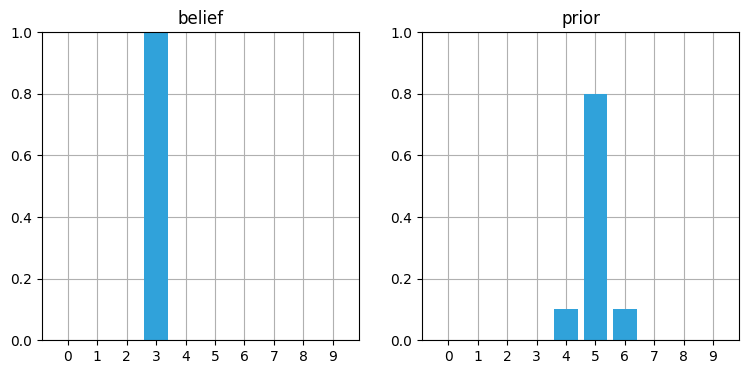

In [22]:
def predict_move(belief, move, p_under, p_correct, p_over):
    n = len(belief)
    prior = np.zeros(n)
    for i in range(n):
        prior[i] = (
            belief[(i-move) % n]   * p_correct +
            belief[(i-move-1) % n] * p_over +
            belief[(i-move+1) % n] * p_under)      
    return prior

belief = [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]
prior = predict_move(belief, 2, .1, .8, .1)
book_plots.plot_belief_vs_prior(belief, prior)

看起来工作正常。如果我们的信念不是100%确定会发生什么呢？

array([0.  , 0.  , 0.  , 0.04, 0.38, 0.52, 0.06, 0.  , 0.  , 0.  ])

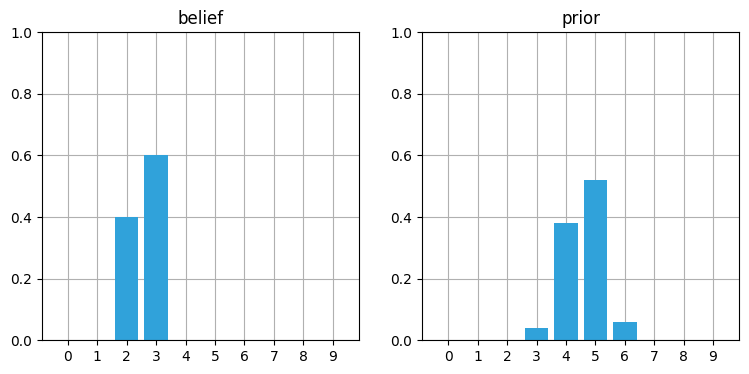

In [23]:
belief = [0, 0, .4, .6, 0, 0, 0, 0, 0, 0]
prior = predict_move(belief, 2, .1, .8, .1)
book_plots.plot_belief_vs_prior(belief, prior)
prior

这些结果更复杂一些，但你应该仍然能够在脑海中进行推断。0.04 是由于 0.4 的信念可能低估了 1。0.38 是由于以下情况：80% 的可能性是我们移动了 2 个位置（0.4 × 0.8），以及10% 的可能性是我们低估了（0.6 × 0.1）。在这里，过度移动并不起作用，因为如果我们过度移动，0.4 和 0.6 都会超过这个位置。**我强烈建议进行一些练习，直到这一点非常清楚，因为后续的许多内容都取决于对这一步骤的理解。**

如果你看了更新后的概率，可能会感到沮丧。在上面的例子中，我们在两个位置的概率分别是 0.4 和 0.6；进行更新后，概率不仅降低了，而且分散在地图上。

这不是巧合，也不是精心选择示例的结果——这总是预测的特点。如果传感器存在噪声，我们每次预测都会丢失一些信息。假设我们无限次进行预测——结果会是什么样的？如果我们每一步都丢失信息，最终我们必定会失去所有信息，概率将在 `belief` 数组上均匀分布。让我们尝试进行 100 次迭代。图表是动画的；使用滑块更改步数。

In [24]:
belief = np.array([1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predict_beliefs = []
    
for i in range(100):
    belief = predict_move(belief, 1, .1, .8, .1)
    predict_beliefs.append(belief)

print('Final Belief:', belief)

# make interactive plot
def show_prior(step):
    book_plots.bar_plot(predict_beliefs[step-1])
    plt.title(f'Step {step}')
    plt.show()

interact(show_prior, step=IntSlider(value=1, max=len(predict_beliefs)));

Final Belief: [0.104 0.103 0.101 0.099 0.097 0.096 0.097 0.099 0.101 0.103]


interactive(children=(IntSlider(value=1, description='step'), Output()), _dom_classes=('widget-interact',))

In [25]:
print('Final Belief:', belief)

Final Belief: [0.104 0.103 0.101 0.099 0.097 0.096 0.097 0.099 0.101 0.103]


100次迭代后，尽管我们最初对起始位置为0有着100%的确信，但几乎失去了所有信息。随意调整数字来观察不同次数的更新效果。比如，经过100次更新后，仍有一点点信息残留；50次更新后保留了很多信息；但是经过200次迭代后，基本上所有信息都丢失了。

如果您是在线观看的话，这里有一个那个输出的动画。

<img src="animations/02_no_info.gif">

